# Sentiment Analysis using IMDb Dataset
### by Wenzhe Ding
---

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called _sentiment analysis_. In this notebook you will build an end-to-end sentiment classification system from scratch.

Please note that this project is part of Udacity's Artifical Intelligence Nanodegree program that I have completed on February 16, 2018. Some template code has already been provided by the program.

## Table of contents
- [Data Exploration](#DataExploration)
- [Data Processing](#DataProcessing)
    - [Text to Words](#TexttoWords)
    - [Bag-of-Words](#Bag-of-Words)
    - [Zipf's law](#Zipf_law)
    - [Normalization](#Normalization)
- [Naive Bayes Classifier](#NaiveBayesClassifier)
- [Gradient-Boosted Decision Tree Classifier](#Gradient-BoostedDecisionTreeClassifier)
- [RNNs](#RNNs)
    - [Load Data](#LoadData)
    - [Pad Sequences](#PadSequences)
    - [Model Building](#ModelBuilding)
- [Next Steps](#NextSteps)

----
<a id='DataExploration'></a>
## Data Exploration
[[ go back to the top ]](#Table-of-contents)

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [1]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][2])

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).


And one with a negative sentiment:

In [3]:
print(data['train']['neg'][2])

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.


We can also make a wordcloud visualization of the postive and negative reviews.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(sentiment):
    # Combine all reviews for the desired sentiment
    combined_text = " ".join([review for review in data['train'][sentiment]])
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50,
            # update stopwords to include common words like film and movie
            stopwords = STOPWORDS.update(['br','film','movie']))
    # Generate and plot wordcloud
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(wc.generate(combined_text))
    ax.axis('off')
    plt.title('Wordcloud of %s Reviews' %sentiment)

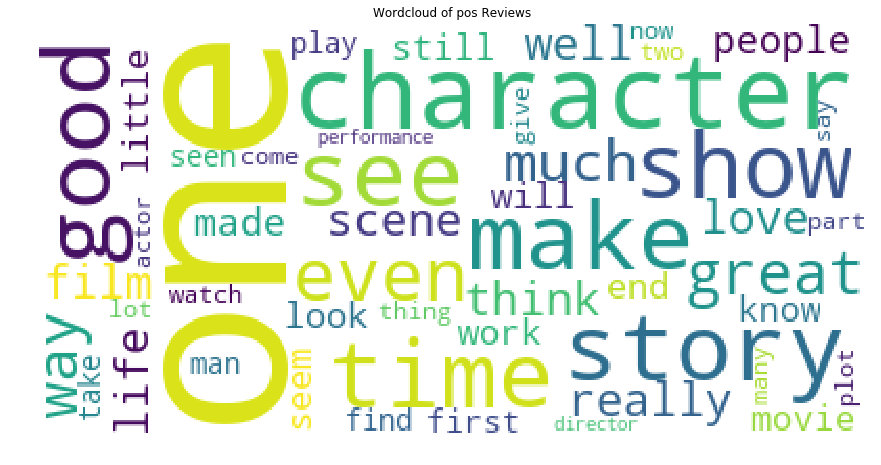

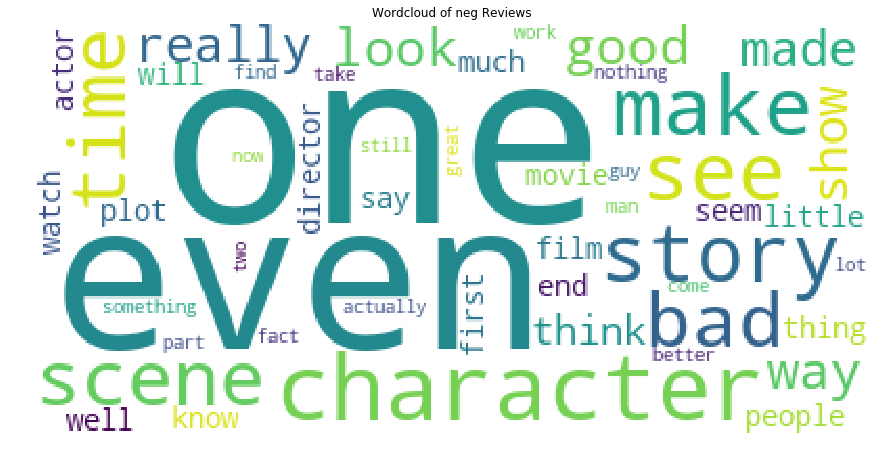

In [5]:
plot_wordcloud('pos')
plot_wordcloud('neg')

From the above plots, we see that there are a few words in common for both plots, such as 'one', 'character', 'time','story' and 'even'. But we see words, such as 'good' and 'great' only in positive reivew and 'bad' and 'better' only in negative reviews. Next, we'll combine the positive and negative documents to get one unified training set and one unified test set.

In [45]:
import numpy as np
from sklearn.utils import shuffle

In [46]:
def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # TODO: Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train, random_state=0)
    data_test, labels_test = shuffle(data_test, labels_test, random_state=0)
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


----
<a id='DataProcessing'></a>
## Data Processing
[[ go back to the top ]](#Table-of-contents)


Our raw data includes HTML, therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

<a id='TexttoWords'></a>
### Text to Words
[[ go back to the top ]](#Table-of-contents)
    
We'll implement a function `review_to_words()` that performs all these steps.

In [48]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /Users/wding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    # Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    text = BeautifulSoup(review, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower() )
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    # Return final list of words
    words = [stemmer.stem(w) for w in words]
    return words

print("Processing the text below:")
tmp = """This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!"""
print(tmp)
print("Result is shown below:")
review_to_words(tmp)

Processing the text below:
This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!
Result is shown below:


['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [51]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (
            cache_data['words_train'], cache_data['words_test'], 
            cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

Wrote preprocessed data to cache file: preprocessed_data.pkl


In [52]:
# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


--- Raw review ---
You better see this episode from the beginning, because if you start to watch it any later, you will be confused as to what is happening to Clark's life.<br /><br />Yet, that is the twist; Clark is stuck in an alternate reality. Lana is devoted to him. Lex lost most of his legs and is in a wheelchair due to the bridge accident when he swerved to miss Clark in the pilot of the series. Martha is married to Lionel. About the only constant is his most loyal friend Chloe, who still believes in who he is. And, oh yeah, he doesn't have any superpowers. He is in a mental institution for putting himself in a fantasy world where he does have powers, and is ridiculed for believing so. Aside from Chloe, there is one mysterious figure who believes in Clark: a black man who in the alternate reality is also a resident of the institution, who believes he is from Mars.<br /><br />Clark must stay true to everything he believes is actual reality, and not get brainwashed by the institu

<a id='Bag-of-Words'></a>
### Bag-of-Words
[[ go back to the top ]](#Table-of-contents)

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well. Note that the set of words in the training set may not be exactly the same as the test set. What do you do if you encounter a word during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

Next, we'll implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

In [53]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer =  CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x) 
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['vignett', 'watcher', 'interact', 'asset', 'florida', 'rental', 'split', 'dana']

--- Preprocessed words ---
['excel', 'reason', 'edison', 'went', 'straight', 'video', 'would', 'land', 'theater', 'crumbl', 'thud', 'movi', 'last', 'entir', 'long', 'peril', 'bore', 'notch', 'lowbrow', 'thank', 'freeman', 'spacey', 'obvious', 'spare', 'two', 'week', 'next', 'film', 'bad', 'guy', 'laughabl', 'action', 'near', 'non', 'exist', 'justin', 'timberlak', 'act', 'hate', 'knock', 'guy', 'sooner', 'realiz', 'pop', 'fort', 'better', 'movi', 'bad', 'mostli', 'like', 'fact', 'cool', 'j', 'given', 'appear', 'shot', 'lead', 'man', 'deserv', 'unlik', 'fellow', 'musician', 'co', 'star', 'act', 'kevin', 'spacey', 'almost', 'alway', 'enjoy', 'well', 'see', 'gulp', 'sever', 'time', 'chew', 'sceneri', 'freeman', 'abil', 'elev', 'flick', 'three', 'star', 'ten', 'good', 'said', 'done', 'ultim', 'error', 'movi', 'mundan', 'tireso

Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

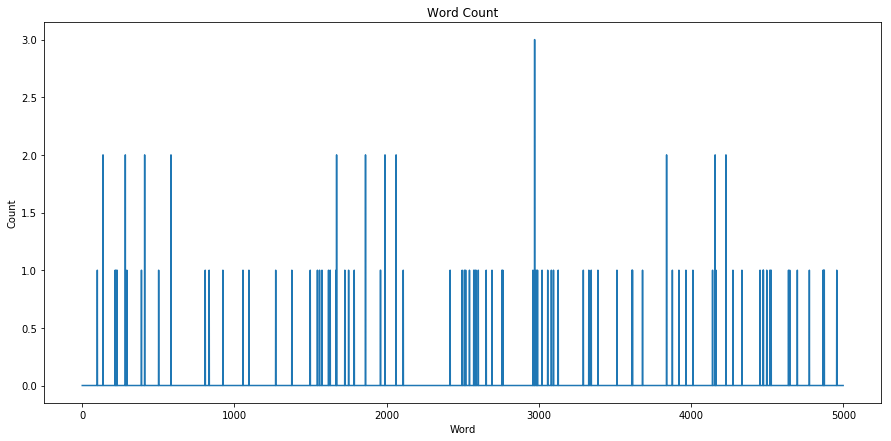

In [58]:
# Plot the BoW feature vector for a training document
plt.figure(figsize=(15,7))
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Word Count')
plt.show()

<a id='Zipf_law'></a>
### Zipf's law
[[ go back to the top ]](#Table-of-contents)

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

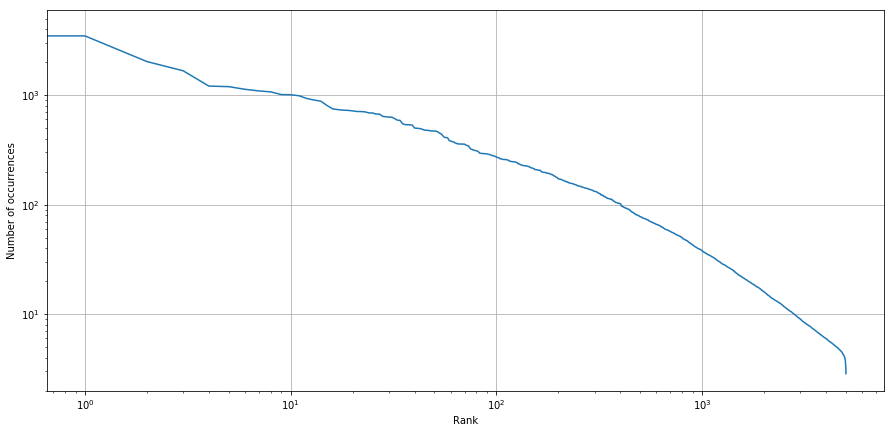

In [74]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.figure(figsize=(15,7))
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
# plt.xticks(np.arange(1, 1000, step=10))
plt.grid()
plt.show()

The most frequent word occured almost 10000 times. 

<a id='Normalization'></a>
### Normalization
[[ go back to the top ]](#Table-of-contents)

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [62]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

----
<a id='NaiveBayesClassifier'></a>
## Naive Bayes Classifier
[[ go back to the top ]](#Table-of-contents)

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [63]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


----
<a id='Gradient-BoostedDecisionTreeClassifier'></a>
## Gradient-Boosted Decision Tree Classifier
[[ go back to the top ]](#Table-of-contents)

Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. Next, we'll improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them and fine tune a parameter: `n_estimators`. Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [79]:
n_estimators = 30

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                     learning_rate=1.0, max_depth=1, random_state=0)
    parameters = {'n_estimators':[10, 20, 30, 40]}
    # Classify the data using GradientBoostingClassifier
    # TODO(optional): Perform hyperparameter tuning / model selection
    clf = GridSearchCV(clf, parameters)
    # TODO: Print final training & test accuracy
    clf.fit(X_train, y_train)
    # Return best classifier model
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(X_train, y_train),
        clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GridSearchCV] Accuracy: train = 0.8056, test = 0.7992


The test accruay increased from 0.72768 to 0.7992. I write a short movie review to trick our machine learning model. Let's see whether it can classify my review incorrectly.

In [82]:
# TODO: Write a sample review and set its true sentiment
my_review = "I wish this movie could be better"
true_sentiment = 'neg'  # sentiment must be 'pos' or 'neg'

my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  
my_bow_features = vectorizer.transform([my_words]).toarray()  
# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, 
                                                             predicted_sentiment))

--- My review ---
I wish this movie could be better

--- Preprocessed words ---
['wish', 'movi', 'could', 'better']

True sentiment: neg, predicted sentiment: pos


----
<a id='RNNs'></a>
## RNNs
[[ go back to the top ]](#Table-of-contents)

We just saw how the task of sentiment analysis can be solved via a traditional machine learning approach: BoW + a nonlinear classifier. We now switch gears and use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras. Conveniently, Keras has a built-in [IMDb movie reviews dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) that we can use, with the same vocabulary size.

<a id='LoadData'></a>
### Load Data
[[ go back to the top ]](#Table-of-contents)

In [83]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), 
                                                                        len(X_test)))

Using TensorFlow backend.


Loaded dataset with 25000 training samples, 25000 test samples


In [84]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

Notice that the label is an integer (0 for negative, 1 for positive), and the review itself is stored as a sequence of integers. These are word IDs that have been preassigned to individual words. To map them back to the original words, we use the dictionary returned by `imdb.get_word_index()`.

In [85]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

1646592/1641221 [==============================] - 1s 0us/step
--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'y

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths, let's print the maximum and minimun review length.

In [88]:
print("maximum review length ", max(len(i) for i in X_train))
print("minimum review length ", min(len(i) for i in X_train))

maximum review length  2494
minimum review length  11


<a id='PadSequences'></a>
### Pad Sequences
[[ go back to the top ]](#Table-of-contents)


In order to feed this data into your RNN, all input documents must have the same length. Let's limit the maximum review length to `max_words` by truncating longer reviews and padding shorter reviews with a null value (0). You can accomplish this easily using the [`pad_sequences()`](https://keras.io/preprocessing/sequence/#pad_sequences) function in Keras. For now, set `max_words` to 500.

In [89]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

<a id='ModelBuilding'></a>
### Model Building
[[ go back to the top ]](#Table-of-contents)

Now we are ready to build and train our RNN model! We'll start with a simple RNN architecture with only layers - an Embedding layer, an LSTM layer and a Drop out layer.

In [90]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# TODO: Design your model
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


During training, we split off a small portion (typically 5-10%) of the training set to be used for validation during training. This will help monitor the training process and identify potential overfitting. Validation metrics are evaluated once at the end of each epoch.

In [92]:
# Compile your model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TODO: Specify training parameters: batch size and number of epochs
# TODO: Specify training parameters: batch size and number of epochs
batch_size = 64
num_epochs = 3

# TODO(optional): Reserve/specify some training data for validation (not to be used for training)
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

# TODO: Train your model
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Train on 24936 samples, validate on 64 samples
Epoch 1/3
24936/24936 [==============================] - 212s 8ms/step - loss: 0.4221 - acc: 0.7986 - val_loss: 0.2440 - val_acc: 0.9219
Epoch 2/3
24936/24936 [==============================] - 208s 8ms/step - loss: 0.2866 - acc: 0.8855 - val_loss: 0.2573 - val_acc: 0.9375
Epoch 3/3
24936/24936 [==============================] - 203s 8ms/step - loss: 0.2334 - acc: 0.9098 - val_loss: 0.2351 - val_acc: 0.9219


In [93]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  
# returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  
# scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.87372


This simple RNN model overperforms both Naive Bayes Classifier and Gradient-Boosted Decision Tree Classifier. 

----
<a id='NextSteps'></a>
### Next Steps
[[ go back to the top ]](#Table-of-contents)


- The first thing is to try and improve the accuracy of the model by experimenting with different architectures, layers and parameters. How good can you get without taking prohibitively long to train? How do you prevent overfitting?

- Then, you may want to deploy your model as a mobile app or web service. What do you need to do in order to package your model for such deployment? How would you accept a new review, convert it into a form suitable for your model, and perform the actual prediction? (Note that the same environment you used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would you modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?
